<h1> # w21040872_Nida_Alyas_KF7032_Final_Assessment </h1>
<h3> Introduction </h3>
We are going to perform Violent Crimes analysis during Lockdown in Britain. The dataset, we will use is realised by UK police related to street level crime and provided in different categories such as domestic, drug abuse and violent crimes. We will analyze the data with different aspects specifically trends of violent crimes during Covid-19 pandemic lockdown as well as before pandemic.

In [25]:
import numpy as np
import pandas as pd
import pyspark
import collections
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages
import itertools

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg, sum, col, to_date, max as max_, min as min_

import statsmodels.api as sm

In [2]:
#Checking for Spark Version and App Name
spark = SparkSession\
.builder\
.appName("Python Spark app")\
.getOrCreate()

#Check we have a spark context: Should show the spark version and app name
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Python Spark app>

<h3> Loading all Datasets </h3>
Crimes and location datasets

In [3]:
#Loading Crimes dataset
%%time
crimes = spark.read.csv("Sample_1pc_Data.csv", header=True, inferSchema= True)

CPU times: user 5.02 ms, sys: 377 µs, total: 5.4 ms
Wall time: 13.8 s


In [13]:
#Loading locations dataset
url_loc = "http://unn-izje1.newnumyspace.co.uk/LSOA_pop_v2.csv"
spark.sparkContext.addFile(url_loc)

locations = spark.read.csv("file://" + SparkFiles.get("LSOA_pop_v2.csv"), header=True, inferSchema= True)

<h3> Dataset Exploration </h3>
Exploring the dataset, checking the shape, shemas, attributes and datatypes of each dataset

In [15]:
#Schema of Crimes Dataset
print("Crimes Dataset")
crimes.printSchema()

#Attributes of allcrimes
print("Crimes columns")
crimes.columns

Crimes Dataset
root
 |-- Crime ID: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- Last outcome category: string (nullable = true)
 |-- Context: string (nullable = true)

Crimes columns


['Crime ID',
 'Month',
 'Reported by',
 'Falls within',
 'Longitude',
 'Latitude',
 'Location',
 'LSOA code',
 'LSOA name',
 'Crime type',
 'Last outcome category',
 'Context']

In [17]:
#Schema of Location Dataset
print("Location Dataset")
locations.printSchema()

#Attributes of location
print("Location Dataset")
locations.columns

Location Dataset
root
 |-- date: integer (nullable = true)
 |-- geography: string (nullable = true)
 |-- geography code: string (nullable = true)
 |-- Rural Urban: string (nullable = true)
 |-- Variable: All usual residents; measures: Value: integer (nullable = true)
 |-- Variable: Males; measures: Value: integer (nullable = true)
 |-- Variable: Females; measures: Value: integer (nullable = true)
 |-- Variable: Lives in a household; measures: Value: integer (nullable = true)
 |-- Variable: Lives in a communal establishment; measures: Value: integer (nullable = true)
 |-- Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value: integer (nullable = true)
 |-- Variable: Area (Hectares); measures: Value: double (nullable = true)
 |-- Variable: Density (number of persons per hectare); measures: Value: double (nullable = true)

Location Dataset


['date',
 'geography',
 'geography code',
 'Rural Urban',
 'Variable: All usual residents; measures: Value',
 'Variable: Males; measures: Value',
 'Variable: Females; measures: Value',
 'Variable: Lives in a household; measures: Value',
 'Variable: Lives in a communal establishment; measures: Value',
 'Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value',
 'Variable: Area (Hectares); measures: Value',
 'Variable: Density (number of persons per hectare); measures: Value']

Checking the first few rows to explore more about given datasets.
we will explore upto 5 rows

In [30]:
print("Crimes dataset (first 5 rows)")
crimes.show(5)

Crimes dataset (first 5 rows)
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|Crime ID|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|Last outcome category|Context|
+--------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+---------------------+-------+
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.345526|51.398948|On or near Daffor...|E01014409|Bath and North Ea...|Anti-social behav...|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and Somerset...|-2.398165|51.398925|On or near Symes ...|E01014477|Bath and North Ea...|         Other crime|                 null|   null|
|    null|2010-12|Avon and Somerset...|Avon and So

In [31]:
print("Location dataset (first 5 rows)")
locations.show(5)

Location dataset (first 5 rows)
+----+---------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|date|      geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|Variable: Lives in a communal establishment; measures: Value|Variable: Schoolchild or full-time student aged 4 and over at their non term-time address; measures: Value|Variable: Area (Hectares); measures: Value|Variable: Density (number of persons per hectare); mea

<h3> Data Preprocessing </h3>
we have to clean the dataset by removing miising values and unnecessary data which has no contribution in our analysis

In [33]:
#dropping unnecessary attributes
crimes = crimes.drop("Crime ID", "Last outcome category", "Context")
crimes.show(5)

+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+
|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|
+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.345526|51.398948|On or near Daffor...|E01014409|Bath and North Ea...|Anti-social behav...|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.398165|51.398925|On or near Symes ...|E01014477|Bath and North Ea...|         Other crime|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.349528|51.393991|On or near Upper ...|E01014467|Bath and North Ea...|Anti-social behav...|
|2010-12|Avon and Somerset...|Avon and Somerset...|-2.361416|51.381448|On or near Westga...|E01014370|Bath and North Ea...|Anti-so

+----------------------------+----------+----------+
|Crime type                  |Start date|End date  |
+----------------------------+----------+----------+
|Violent crime               |2010-12-01|2013-04-01|
|Other crime                 |2010-12-01|2021-05-01|
|Burglary                    |2010-12-01|2021-05-01|
|Robbery                     |2010-12-01|2021-05-01|
|Vehicle crime               |2010-12-01|2021-05-01|
|Anti-social behaviour       |2010-12-01|2021-05-01|
|Public disorder and weapons |2011-09-01|2013-04-01|
|Drugs                       |2011-09-01|2021-05-01|
|Shoplifting                 |2011-09-01|2021-05-01|
|Other theft                 |2011-09-01|2021-05-01|
|Criminal damage and arson   |2011-09-01|2021-05-01|
|Bicycle theft               |2013-05-01|2021-05-01|
|Public order                |2013-05-01|2021-05-01|
|Possession of weapons       |2013-05-01|2021-05-01|
|Theft from the person       |2013-05-01|2021-05-01|
|Violence and sexual offences|2013-05-01|2021-

<h3>Merge both datasets</h3>
We need to merge locations and crimes datsets on the basis of specific features (LSOA code & Geography Code) using join function.Save the new merged dataset in a dataframe for further analysis.

In [42]:
#Merging location and crimes datasets
merged_dataset = crimes.join(locations,crimes["LSOA code"] == locations["geography code"],how='inner')
#Checking the schema (either successfully merged or not)
merged_dataset.printSchema()

root
 |-- Month: string (nullable = true)
 |-- Reported by: string (nullable = true)
 |-- Falls within: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- LSOA code: string (nullable = true)
 |-- LSOA name: string (nullable = true)
 |-- Crime type: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- geography: string (nullable = true)
 |-- geography code: string (nullable = true)
 |-- Rural Urban: string (nullable = true)
 |-- Variable: All usual residents; measures: Value: integer (nullable = true)
 |-- Variable: Males; measures: Value: integer (nullable = true)
 |-- Variable: Females; measures: Value: integer (nullable = true)
 |-- Variable: Lives in a household; measures: Value: integer (nullable = true)
 |-- Variable: Lives in a communal establishment; measures: Value: integer (nullable = true)
 |-- Variable: Schoolchild or full-time student aged 4 and over at their no

In [43]:
#showing first few rows of dataset
merged_dataset.show(5)

+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+----+--------------------+--------------+-----------+----------------------------------------------+--------------------------------+----------------------------------+-----------------------------------------------+------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+------------------------------------------+------------------------------------------------------------------+
|  Month|         Reported by|        Falls within|Longitude| Latitude|            Location|LSOA code|           LSOA name|          Crime type|date|           geography|geography code|Rural Urban|Variable: All usual residents; measures: Value|Variable: Males; measures: Value|Variable: Females; measures: Value|Variable: Lives in a household; measures: Value|V

<p>Now we have location as well as crimes in one dataset named as merged dataset.

we already droped irrelevent attributes. we have merged cleaned dataset. </p>

<h3> Q.1 What Crime Categories does the Police Data Use? </h3>
We have to show all crime categories that are being used in 
police data. Firstly all of distinct crimes along with names of crime categories 
and there overall count will be shown.

In [51]:
# Getting Name of Distinct Crime Types with their Overall Count
df_crime = crimes.groupby('Crime Type').count().toPandas()
df_crime

,Crime Type,count
0,Bicycle theft,7349
1,Public order,25726
2,Drugs,16914
3,Public disorder and weapons,2425
4,Other crime,25794
5,Robbery,6776
6,Criminal damage and arson,53547
7,Theft from the person,7041
8,Shoplifting,32354
9,Burglary,43382


<h3>Answer: </h3> 
Police dataset contains 15 different crime categories such as Bicycle theft, police order, drugs, public disorder and weapons,
other crime, robbery, criminal damage and arson, theft from the person, shoplifting, burglary, voilent crime, other theft,
possession of weapons, violence and sexual offences, vehicle crime, and anti social behavior.

<h3> Q.2 Have the Same Categories been Used Consistently? </h3> 
First of all, showing and filtering crimes categories w.r.t to start and end dates of crimes so that we can
check the consistency of crime categories

In [53]:
#crimes categories with dates (Start and End)
crimes.withColumn("Month", to_date(col("Month"),"yyyy-MM")).groupBy("Crime type").agg(min_("Month").alias("Start date"), max_("Month").alias("End date")).orderBy("Start date","End date").show(truncate=False)

+----------------------------+----------+----------+
|Crime type                  |Start date|End date  |
+----------------------------+----------+----------+
|Violent crime               |2010-12-01|2013-04-01|
|Other crime                 |2010-12-01|2021-05-01|
|Burglary                    |2010-12-01|2021-05-01|
|Robbery                     |2010-12-01|2021-05-01|
|Vehicle crime               |2010-12-01|2021-05-01|
|Anti-social behaviour       |2010-12-01|2021-05-01|
|Public disorder and weapons |2011-09-01|2013-04-01|
|Drugs                       |2011-09-01|2021-05-01|
|Shoplifting                 |2011-09-01|2021-05-01|
|Other theft                 |2011-09-01|2021-05-01|
|Criminal damage and arson   |2011-09-01|2021-05-01|
|Bicycle theft               |2013-05-01|2021-05-01|
|Public order                |2013-05-01|2021-05-01|
|Possession of weapons       |2013-05-01|2021-05-01|
|Theft from the person       |2013-05-01|2021-05-01|
|Violence and sexual offences|2013-05-01|2021-

<h3>Answer: </h3> 
<p>From above table we can clearly note that all the categories are not consistent, particularly changed after 2013.
But most of the categories exist throughout the tenure till 2021 except 2 categories such as
violent crime and public disorders and weapons.
Both categories doesnot exist and it's end date is in 2013. Similarly many categories started from 2013 such as
Bicycle theft, Public order, Possession of weapons, Theft from person and Violence and sexual offences. It seems
Violent crime named as Violence and sexual offences after 2013.</p>

<h3>Q3: Are levels of violent crime constant, increasing, or decreasing?</h3>
<p>Firstly, we will filter specific crime category (violent crime) and merge with updated category
    named as Violence and sexual offences.
    
Secondly, total count of violent crimes from 2010 till 2021 as per merged dataset category.
    
Finally, Show all Violent crimes with Date and Month using Data/Timestamp.</p>

In [76]:
violent_crimes = merged_dataset.select(to_date(col("Month"),"yyyy-MM").alias("date"),'Location','LSOA code','LSOA name','Crime type')\
.where((merged_dataset["Crime type"] == 'Violence and sexual offences'))
violent_crimes.show(10)

#Total count of violent crime
violent_crimes.count()

+----------+--------------------+---------+--------------------+--------------------+
|      date|            Location|LSOA code|           LSOA name|          Crime type|
+----------+--------------------+---------+--------------------+--------------------+
|2013-05-01|On or near Calder...|E01014398|Bath and North Ea...|Violence and sexu...|
|2013-05-01|On or near Manver...|E01014371|Bath and North Ea...|Violence and sexu...|
|2013-05-01|On or near Old Mi...|E01033078|Bath and North Ea...|Violence and sexu...|
|2013-05-01|On or near Frankl...|E01014486|        Bristol 023B|Violence and sexu...|
|2013-05-01|On or near Weaver...|E01014684|        Bristol 029E|Violence and sexu...|
|2013-05-01|On or near Corn S...|E01014540|        Bristol 032B|Violence and sexu...|
|2013-05-01|On or near Harbou...|E01033345|        Bristol 032F|Violence and sexu...|
|2013-05-01|On or near Newlan...|E01014756| North Somerset 010A|Violence and sexu...|
|2013-05-01|On or near Baker ...|E01014800| North Some

108252

In [80]:
violent_crimes_count = violent_crimes.groupBy(violent_crimes.date).count().orderBy(violent_crimes.date)
violent_crimes_count.show()

+----------+-----+
|      date|count|
+----------+-----+
|2013-05-01|  512|
|2013-06-01|  546|
|2013-07-01|  582|
|2013-08-01|  523|
|2013-09-01|  504|
|2013-10-01|  572|
|2013-11-01|  570|
|2013-12-01|  586|
|2014-01-01|  507|
|2014-02-01|  558|
|2014-03-01|  589|
|2014-04-01|  603|
|2014-05-01|  643|
|2014-06-01|  718|
|2014-07-01|  723|
|2014-08-01|  659|
|2014-09-01|  695|
|2014-10-01|  707|
|2014-11-01|  706|
|2014-12-01|  739|
+----------+-----+
only showing top 20 rows



In [81]:
violent_crimes_count = violent_crimes_count.toPandas()
violent_crimes_count

,date,count
0,2013-05-01,512
1,2013-06-01,546
2,2013-07-01,582
3,2013-08-01,523
4,2013-09-01,504
...,...,...
92,2021-01-01,1377
93,2021-02-01,1266
94,2021-03-01,1609
95,2021-04-01,1467


<h3> Plot Violent Crimes Trend from 2014 to 2021 </h3> 
    In below graph,It is noted that violent crime is gradually increasing each year. In March 2020,
There is downward trend. Again in 2020, we can see fluctuations and in mid 2020 violent crimes 
were on it's peak value.

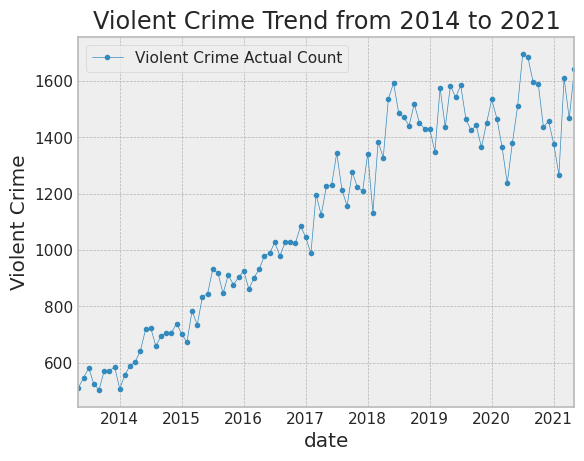

In [83]:
violent_crimes_count.date = violent_crimes_count.date.astype('datetime64[ns]')
violent_crimes_count_upd = violent_crimes_count.set_index(pd.to_datetime(violent_crimes_count.date))
plt.figsize=(20, 6)
violent_crimes_count_upd.plot(y='count', x='date', marker='.', linestyle='-', linewidth=0.5,\
         subplots=False,
              label='Violent Crime Actual Count',
              title='Violent Crime Trend from 2014 to 2021')
plt.style.use(['bmh'])
plt.ylabel('Violent Crime')
plt.show()

<h3> Plot Crimes from 2014 to 2021 (Frequency and Trend) </h3>


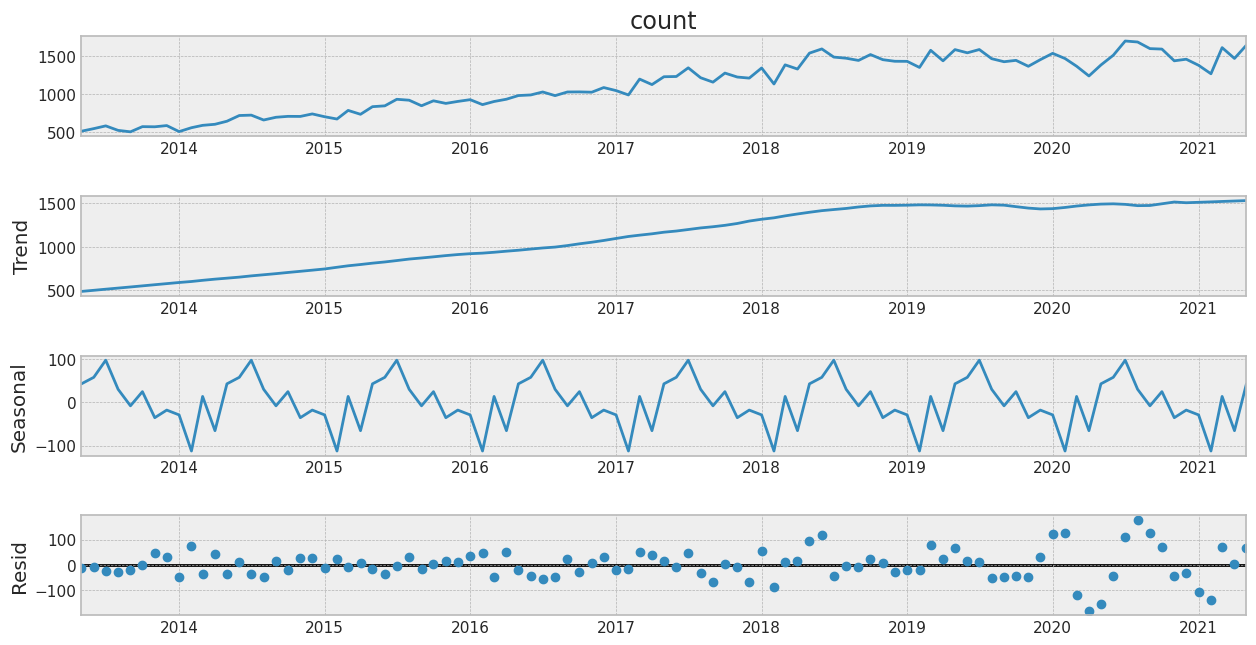

In [88]:
violent_crime_decompse = sm.tsa.seasonal_decompose(violent_crimes_count_upd['count'], model='additive',extrapolate_trend='freq')
fig = violent_crime_decompse.plot()
fig.set_size_inches(14,7)
plt.show()

<h3> Q.4 Use Data before First Lockdown and Predict Violent Crime Levels for April-2020 </h3>
Filtering and Counting the Violent Crimes 
Plotting Violent Crimes Trend Before Pandemic

In [90]:
# Extarcting Data before pandemic
violent_crimes_A2020 = violent_crimes_count_upd[(violent_crimes_count_upd.date.dt.year > 2013) & (violent_crimes_count_upd.date.dt.year < 2021)]
violent_crimes_A2020

,date,count
date,,
2014-01-01,2014-01-01,507
2014-02-01,2014-02-01,558
2014-03-01,2014-03-01,589
2014-04-01,2014-04-01,603
2014-05-01,2014-05-01,643
...,...,...
2020-08-01,2020-08-01,1683
2020-09-01,2020-09-01,1596
2020-10-01,2020-10-01,1590


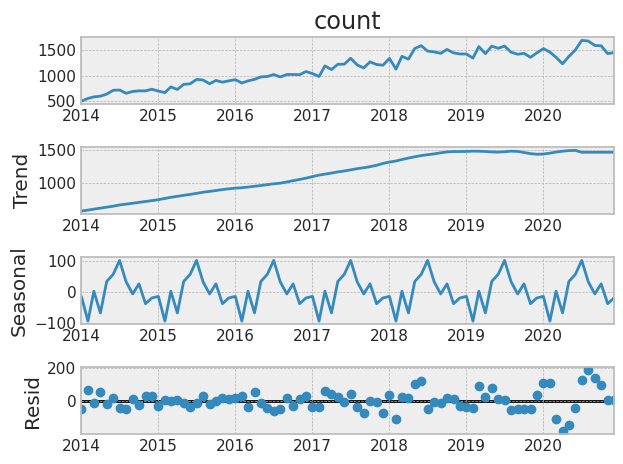

In [91]:
violent_crime_trend_count= sm.tsa.seasonal_decompose(violent_crimes_A2020['count'], model='additive',extrapolate_trend='freq')
fig = violent_crime_trend_count.plot()
plt.show()

<h3>Data Visualization using The Rolling statistics test.</h3>

<p>Plotting the rolling mean and rolling standard deviation graph which is not constant, 
it is now clear that given dataset is not stationary<p/>

In [92]:
### plotting Rolling Statistic to check Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 640x480 with 0 Axes>

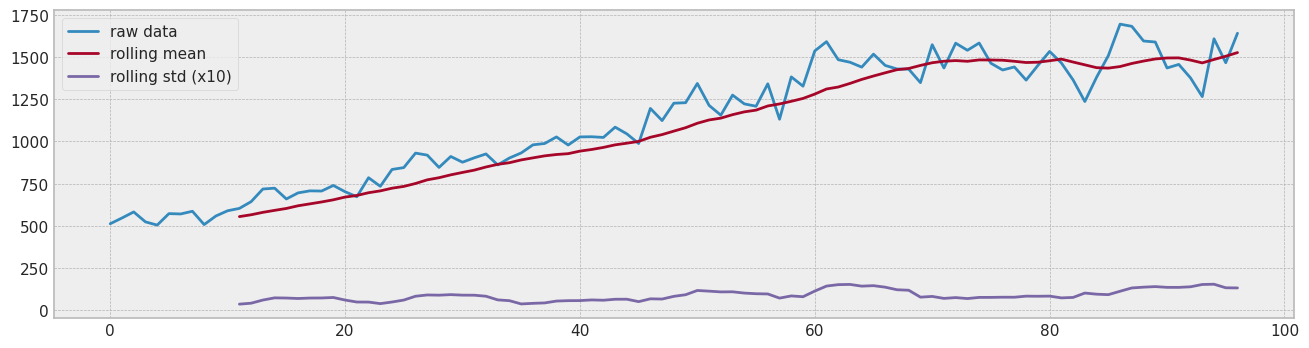

In [93]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(violent_crimes_count['count'],'raw data')

<h3>Performing the Augmented Dickey-Fuller Test</h3>

<p>We are assuming and drawing hypothesis that the data is non-stationary. 
Statistics test and few other critical values demonstrates that data is not stationarity as shown is results below.</p>

In [95]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [96]:
ADF_test(violent_crimes_count['count'],'raw data')

 > Is the raw data stationary ?
Test statistic = -2.017
P-value = 0.279
Critical values :
	1%: -3.5097356063504983 - The data is not stationary with 99% confidence
	5%: -2.8961947486260944 - The data is not stationary with 95% confidence
	10%: -2.5852576124567475 - The data is not stationary with 90% confidence


<h3>Performing and plotting Detrending</h3>
Removing a trend to eliminate distortion from a time series data.

<Figure size 640x480 with 0 Axes>

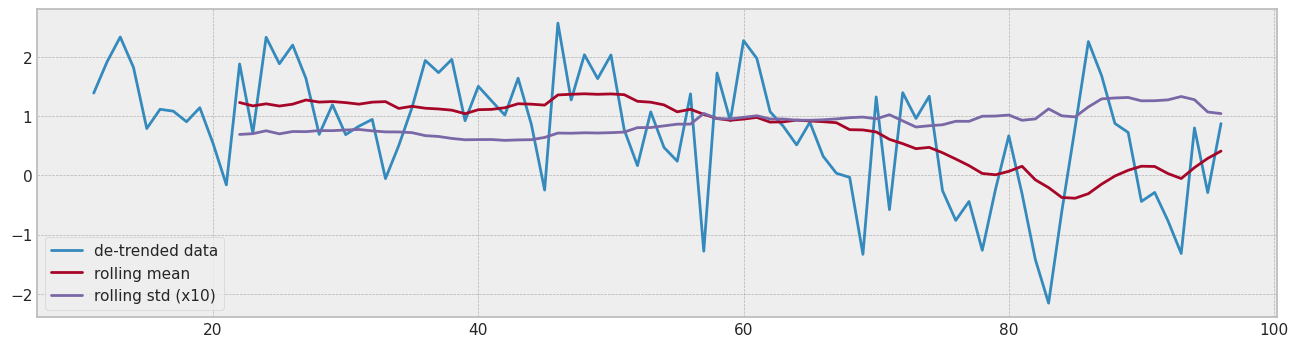

 > Is the de-trended data stationary ?
Test statistic = -0.884
P-value = 0.793
Critical values :
	1%: -3.5219803175527606 - The data is not stationary with 99% confidence
	5%: -2.9014701097664504 - The data is not stationary with 95% confidence
	10%: -2.58807215485756 - The data is not stationary with 90% confidence


In [98]:
# Detrending
y = violent_crimes_count['count']
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

<h3> Differencing </h3>
Removing the time dependent aspects and performing the data transformation.

<Figure size 640x480 with 0 Axes>

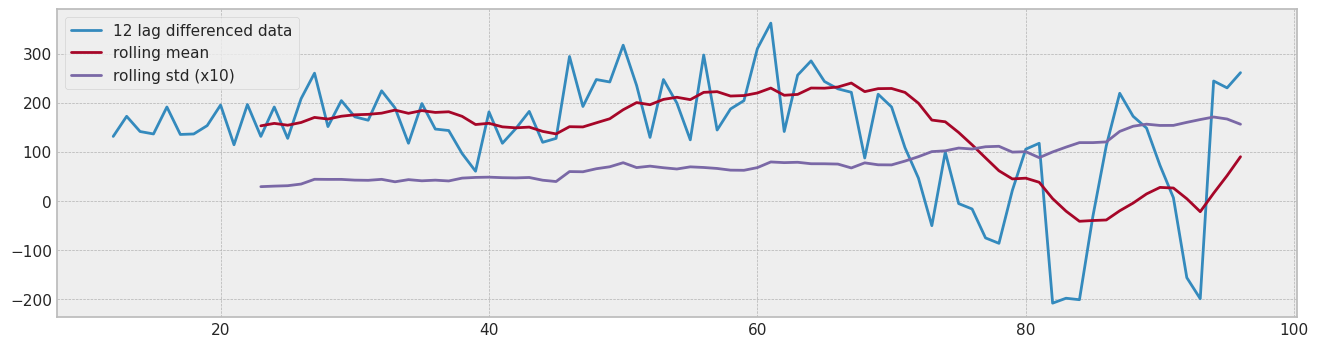

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.362
P-value = 0.600
Critical values :
	1%: -3.524624466842421 - The data is not stationary with 99% confidence
	5%: -2.9026070739026064 - The data is not stationary with 95% confidence
	10%: -2.5886785262345677 - The data is not stationary with 90% confidence


In [99]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

<Figure size 640x480 with 0 Axes>

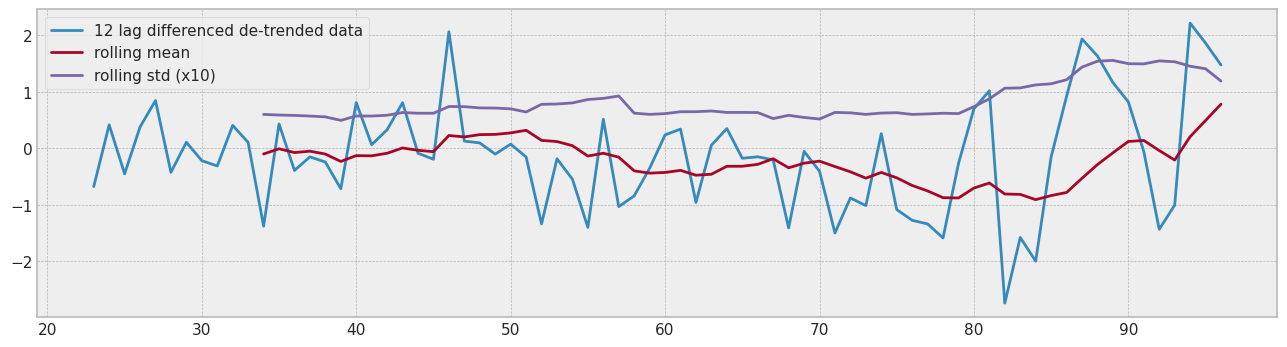

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -2.378
P-value = 0.148
Critical values :
	1%: -3.542412746661615 - The data is not stationary with 99% confidence
	5%: -2.910236235808284 - The data is not stationary with 95% confidence
	10%: -2.5927445767266866 - The data is not stationary with 90% confidence


In [100]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')

ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [101]:
pdf = pd.DataFrame(y_12lag_detrend).reset_index()
pdf.columns = ['Date','Count']
pdf

,Date,Count
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
92,92,-1.43385007
93,93,-1.00665714
94,94,2.21875145
95,95,1.86503090


<h3> Q.5 Compare predicted crime levels with actuals, and so determine whether significant changes to violent crime occurred </h3>
First of all, splitting the dataset into training and testing dataset.
Secondly, comparing predicted crime levels with actuals, and analyzing significant changes in violent crime category.

In [103]:
pdf.Date = pdf.Date.astype('datetime64[ns]')
y = pdf.set_index(pd.to_datetime(pdf.Date)).dropna().Count
y.head()

Date
1970-01-01 00:00:00.000000023   -0.67788491
1970-01-01 00:00:00.000000024    0.41706673
1970-01-01 00:00:00.000000025   -0.45085455
1970-01-01 00:00:00.000000026    0.37884832
1970-01-01 00:00:00.000000027    0.84726844
Name: Count, dtype: float64

In [104]:
y_to_train = y[:'2020-03-01'] # dataset to train
y_to_test = y['2020-04-01': ] # last X months for test  
#predict_date = len(y) - len(y[:'2019-02-01']) # the number of data points for the test set
y_to_val = y_to_test

<h3> ARIMA (Autoregressive integrated moving average) </h3>
For trends prediction, one of the most popular statistical analysis model (ARIMA) will be used.

In [106]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


<h3> Fit and train the ARIMA </h3>

In [107]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:208.30498524013944
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:196.23292662380433
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:238.73623981717515
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:207.4015007507419
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:195.98441503193044
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:197.8878159938487
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:212.0137898855993
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:200.2960896043793
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:199.96241149341117
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:182.5003756562954
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:235.1245660925449
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:201.4200969894369
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:184.13341383556298
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:184.49083748475206
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:205.92282274337856
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:193.1409086557572
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:220.18091659038257
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:185.86462814240292


<h3> Plotting the results </h3>

In [110]:
order = (0, 0, 0) #Using Values from the previous step
seasonal_order = (0, 0, 1, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

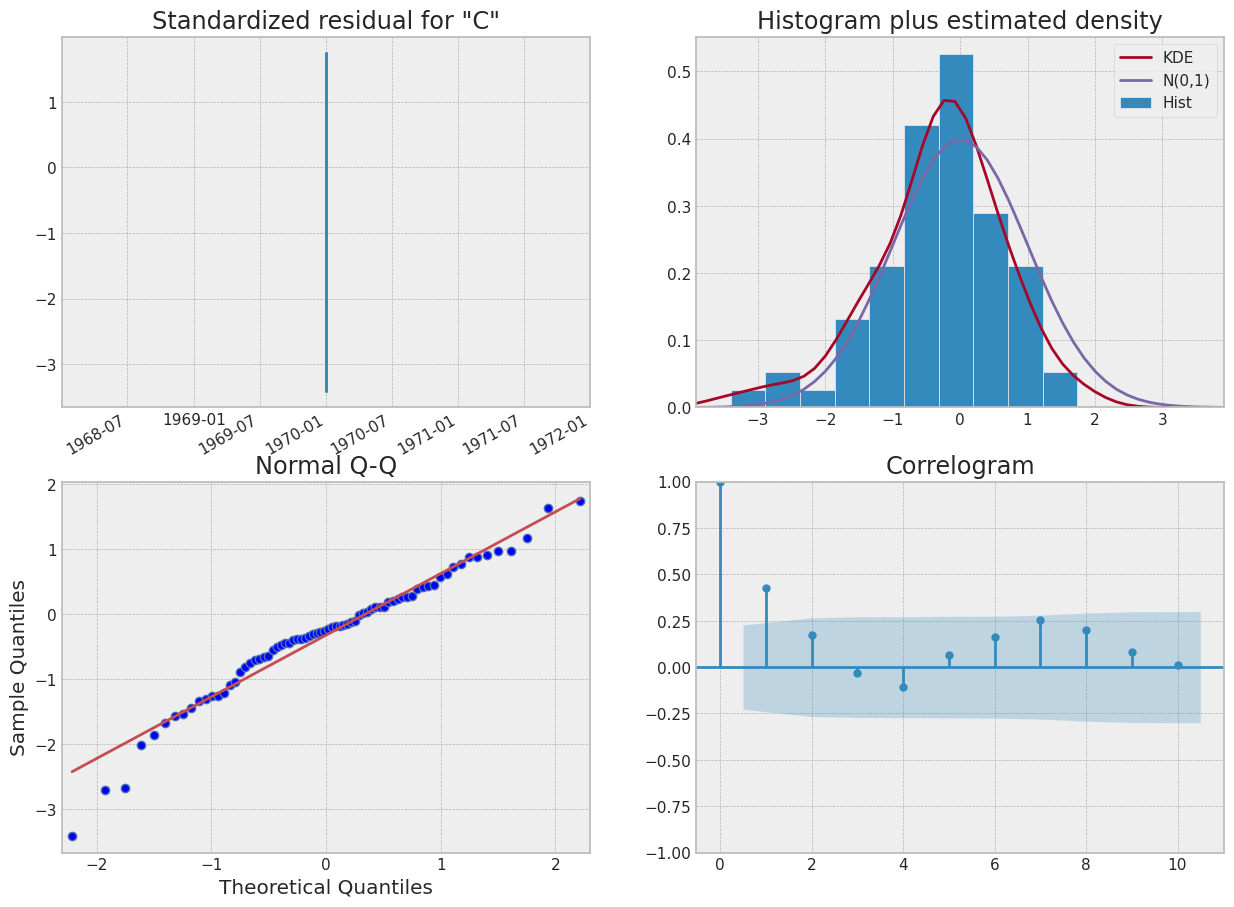

In [111]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [113]:
#Predicting Based on Previous Data
pred_uc = results.get_forecast(steps=12)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
pred_ci = pred_uc.conf_int()

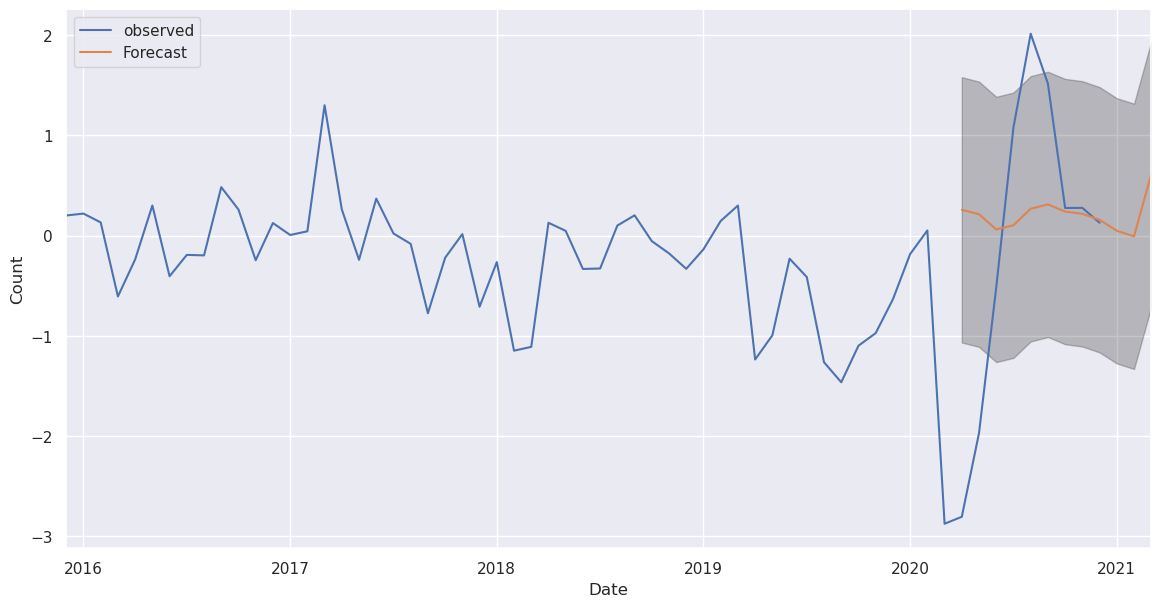

In [51]:
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

In [114]:
# Produce the Prediction tables 
pm = pred_uc.predicted_mean.reset_index()
pm.columns = ['Date','Predicted_Mean']
pci = pred_ci.reset_index()
pci.columns = ['Date','Lower Bound','Upper Bound']
final_table = pm.join(pci.set_index('Date'), on='Date')
final_table.head(9)

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,1970-01-01 00:00:00.000000097,0.26392762,-1.44071053,1.96856577
1,1970-01-01 00:00:00.000000098,-0.38913847,-2.09377662,1.31549968
2,1970-01-01 00:00:00.000000099,-0.65504345,-2.35968160,1.04959470
3,1970-01-01 00:00:00.000000100,-0.47137420,-2.17601235,1.23326395
4,1970-01-01 00:00:00.000000101,-0.22940578,-1.93404392,1.47523237
5,1970-01-01 00:00:00.000000102,-0.00741356,-1.71205171,1.69722459
6,1970-01-01 00:00:00.000000103,0.15268390,-1.55195425,1.85732205
7,1970-01-01 00:00:00.000000104,0.62744341,-1.07719474,2.33208156
8,1970-01-01 00:00:00.000000105,0.30241699,-1.40222116,2.00705514


In [115]:
y_to_test.head(10)

Series([], Name: Count, dtype: float64)

<h3> Q.6 The Leicester region was put in a Local Lockdown in July-2020. Verify Your Findings (if any) with Respect to that Region only? </h3>

In [119]:
#filerting leicester
leicester = merged_dataset.select('Reported by', to_date(col("Month"),"yyyy-MM").alias("Date"),'Location', 'Latitude', 'Longitude','LSOA code','geography','Crime type')\
.where("geography like 'Leicester%'")
leicester.show(5)

+--------------------+----------+--------------------+---------+---------+---------+--------------+--------------------+
|         Reported by|      Date|            Location| Latitude|Longitude|LSOA code|     geography|          Crime type|
+--------------------+----------+--------------------+---------+---------+---------+--------------+--------------------+
|Leicestershire Po...|2010-12-01|On or near St. Me...|52.676365|-1.161399|E01013615|Leicester 001A|         Other crime|
|Leicestershire Po...|2010-12-01|On or near Thatch...| 52.66323|-1.162597|E01013619|Leicester 001D|         Other crime|
|Leicestershire Po...|2010-12-01|On or near Fowler...|52.662683|-1.151444|E01013620|Leicester 004B|Anti-social behav...|
|Leicestershire Po...|2010-12-01|On or near Iona C...|52.660156|-1.162714|E01013622|Leicester 004D|         Other crime|
|Leicestershire Po...|2010-12-01|On or near Overin...|52.660979|-1.123532|E01013628|Leicester 006B|Anti-social behav...|
+--------------------+----------

In [123]:
leicester.count()

4440

In [121]:
#Saving in CSV file according to the specific region
final_table.to_csv("w21040872_final_table.csv")
final_table

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,1970-01-01 00:00:00.000000097,0.26392762,-1.44071053,1.96856577
1,1970-01-01 00:00:00.000000098,-0.38913847,-2.09377662,1.31549968
2,1970-01-01 00:00:00.000000099,-0.65504345,-2.35968160,1.04959470
3,1970-01-01 00:00:00.000000100,-0.47137420,-2.17601235,1.23326395
4,1970-01-01 00:00:00.000000101,-0.22940578,-1.93404392,1.47523237
5,1970-01-01 00:00:00.000000102,-0.00741356,-1.71205171,1.69722459
6,1970-01-01 00:00:00.000000103,0.15268390,-1.55195425,1.85732205
7,1970-01-01 00:00:00.000000104,0.62744341,-1.07719474,2.33208156
8,1970-01-01 00:00:00.000000105,0.30241699,-1.40222116,2.00705514
9,1970-01-01 00:00:00.000000106,-0.39292461,-2.09756276,1.31171353
